In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import optuna
import wandb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

wandb.login(key="d12da696b882ebdf6b786d182d46febc1a77dcdb")

cuda


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: diab55 (diab55-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib  # לשמירת ה-LabelEncoder (אופציונלי)

# --- טעינת הדאטה ---
df = pd.read_csv("/kaggle/input/12345678/ct-berteda2 - ct-berteda2.csv")

# שינוי שם עמודת הטקסט
df = df.rename(columns={'fully_clean_text': 'Tweet'})

# קידוד התוויות ממחרוזות למספרים
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

# שמירת המיפוי לשימוש עתידי (אופציונלי)
joblib.dump(label_encoder, "label_encoder.pkl")

# הצגת המיפוי
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

# --- חלוקה ל-Train / Eval /  ---
train_df, eval_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)


# שמירה של רק העמודות הדרושות למודל
train_df = train_df[['Tweet', 'label']]
eval_df = eval_df[['Tweet', 'label']]


# שמירת קבצים
train_df.to_csv("train_data.csv", index=False)
eval_df.to_csv("eval_data.csv", index=False)

print(train_df['Tweet'].iloc[80])

0 → Extremely Negative
1 → Extremely Positive
2 → Negative
3 → Neutral
4 → Positive
stupid as fuck we got things to do and economy to run most business are being shut down and people are not spending on supermarket our couriers especially jnt express are overload please cooperate it for us eventually at the end of the day


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# ===== 1) Base architecture =====
model_name = "digitalepidemiologylab/covid-twitter-bert"
num_labels = 5
CKPT_PATH = "/kaggle/input/123332221/best_model_trial_1.pt"  # <-- your file

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
).to(device)

# ===== 2) Load checkpoint =====
ckpt = torch.load(CKPT_PATH, map_location=device)

# support both formats: pure state_dict OR {"model_state_dict": ...}
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

# ---- strip ONLY the "module." prefix when present (from DataParallel) ----
clean_state = {}
for k, v in state_dict.items():
    if k.startswith("module."):
        clean_state[k[len("module."):]] = v
    else:
        clean_state[k] = v

# ---- (optional) drop classifier head keys if shapes don't match ----
model_state = model.state_dict()
filtered = {}
dropped = []
for k, v in clean_state.items():
    if k in model_state:
        if model_state[k].shape == v.shape:
            filtered[k] = v
        else:
            # if the saved head has a different shape (e.g., different num_labels)
            if k.startswith(("classifier.", "score.", "classification_head.")):
                dropped.append(k)
            else:
                # keep non-head mismatches out to avoid errors
                # (rare unless architecture changed)
                pass
    else:
        # keys that don't exist in current model_state will be treated as 'unexpected'
        # we simply don't include them in filtered
        pass

missing, unexpected = model.load_state_dict(filtered, strict=False)

print(f"Loaded checkpoint: {CKPT_PATH}")
print(f"Dropped classifier keys due to shape mismatch: {len(dropped)}")
if dropped:
    for dk in dropped[:8]:
        print("  -", dk)
    if len(dropped) > 8:
        print(f"  ... and {len(dropped)-8} more")

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

2025-08-19 14:21:10.729440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755613270.911239      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755613270.959916      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded checkpoint: /kaggle/input/123332221/best_model_trial_1.pt
Dropped classifier keys due to shape mismatch: 0
Missing keys: []
Unexpected keys: []


In [4]:
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe['Tweet'].tolist()
        self.labels = dataframe['label'].tolist() 
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=96,  
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torch import nn

# חישוב משקלי תוויות לפי הופעה בפועל — על ה-TRAIN בלבד
train_labels = train_df['label'].values
classes = np.unique(train_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)

# הפיכה לטנסור לשימוש בתוך CrossEntropyLoss
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)

# פונקציית הפסד עם משקלים
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# אופציונלי: להדפיס כדי לדעת מה קיבלת
print("Classes:", classes)
print("Class weights:", class_weights)


Classes: [0 1 2 3 4]
Class weights: [1.49408811 1.2373535  0.82876678 1.08173856 0.71866491]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/751167759.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 2/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 3/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 4/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 5/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a161752f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a161752f560>
Traceback (most recent call l

Epoch 6/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a161752f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a161752f560>
Traceback (most recent call l

Epoch 7/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 8/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 9/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 10/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a161752f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a161752f560>
Traceback (most recent call l

Epoch 11/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 12/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 13/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 14/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 15/15:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_36/751167759.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/751167759.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Best val acc: 0.7457
Best checkpoint saved to: ./final_20ep_checkpoints/best_model_final-ex4.pt


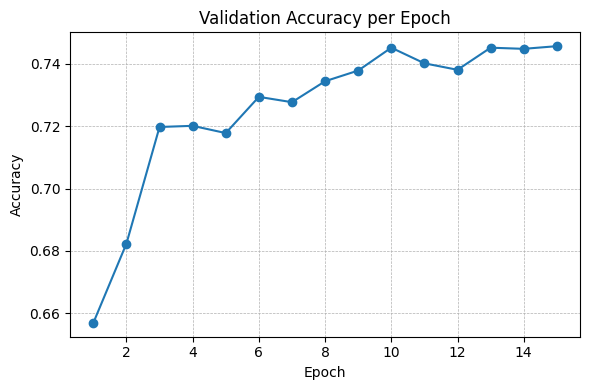

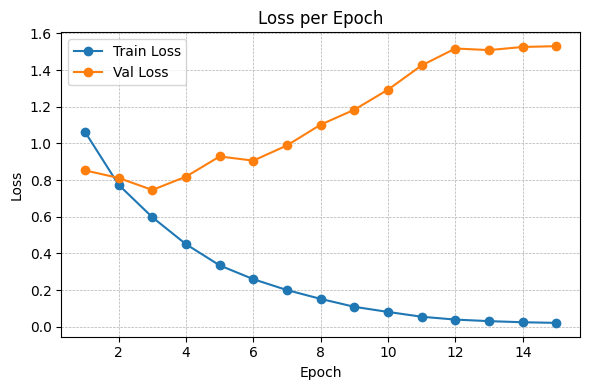

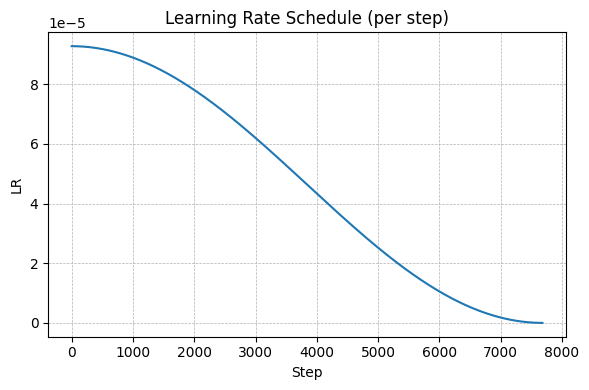

Saved figures to: /kaggle/working/val_accuracy_per_epoch.png, /kaggle/working/loss_per_epoch.png, /kaggle/working/lr_schedule.png


epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇████
step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
train/epoch_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
train/loss,██▇▅▅▅▃▄▅▃▃▄▂▂▂▂▂▂▃▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁
train/lr,████████▇▇▇▇▇▇▇▇▆▆▅▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val/acc,▁▃▆▆▆▇▇▇▇██▇███
val/f1_macro,▁▃▆▆▆▇▇▇▇█▇▇███
val/loss,▂▂▁▂▃▂▃▄▅▆▇████
epoch,15
step,7650
train/epoch_loss,0.02108


In [7]:
# =========================
# 0) Imports & basic config
# =========================
import os
import math
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import wandb

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1_macro": []
}

# (optional) track LR across steps to visualize the scheduler curve
lr_history = []


# ========= W&B toggle =========
USE_WANDB = True
WANDB_PROJECT = "Finetune-ex4-ct"
RUN_NAME = "final-ex4"

# ======================================
# 1) Fill in best hyperparameters (from Optuna)
# ======================================

best_params = {'learning_rate': 9.279423393141813e-05, 'weight_decay': 2.8967896369902165e-05, 'patience': 2, 'batch_size': 64, 'num_layers': 4}
EPOCHS = 15
GRAD_CLIP_NORM = 1.0  # gradient clipping
EVAL_EVERY_EPOCH = True
SAVE_DIR = "./final_20ep_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ======================================
# 2) Tokenizer, datasets, dataloaders
# ======================================
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert", use_fast=False)

train_dataset = TweetDataset(train_df, tokenizer)
val_dataset   = TweetDataset(eval_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=best_params["batch_size"], shuffle=False, num_workers=2)

# ======================================
# 3) Model + freezing policy
# ======================================
num_labels = 5  # adjust if needed
model = AutoModelForSequenceClassification.from_pretrained(
    "digitalepidemiologylab/covid-twitter-bert", num_labels=num_labels
).to(device)

# Freeze all encoder layers
for p in model.bert.parameters():
    p.requires_grad = False

# Unfreeze last k transformer blocks
k = best_params["num_layers"]          # CT‑BERT is BERT‑Large: 24 layers available
for p in model.bert.encoder.layer[-k:].parameters():
    p.requires_grad = True

# Always train the classifier head
for p in model.classifier.parameters():
    p.requires_grad = True


# ======================================
# 4) Loss, optimizer, scheduler
# ======================================
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # ensure class_weights_tensor is on `device`
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=best_params["learning_rate"],
    weight_decay=best_params["weight_decay"]
)

# Optional: cosine schedule without restarts (simple, robust)
# You can also try OneCycleLR if you prefer.
total_steps = len(train_loader) * EPOCHS
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

# Mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ======================================
# 5) Helper: evaluation
# ======================================
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        total_loss += loss.item() * input_ids.size(0)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds  = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1m = f1_score(all_labels, all_preds, average="macro")
    return {"val_loss": avg_loss, "val_acc": acc, "val_f1_macro": f1m}

# ======================================
# 6) Training loop (15 epochs)
# ======================================
if USE_WANDB:
    wandb.init(
        project=WANDB_PROJECT,
        name=RUN_NAME,
        config=dict(best_params, epochs=EPOCHS, architecture="ctweetbert-Large", mode="non-HF")
    )
    wandb.watch(model, log="all", log_freq=200)

best_val_acc = -1.0
best_path = os.path.join(SAVE_DIR, f"best_model_{RUN_NAME}.pt")

global_step = 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for batch in pbar:
        optimizer.zero_grad(set_to_none=True)

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        # gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)

        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        lr_history.append(scheduler.get_last_lr()[0])

        running_loss += loss.item() * input_ids.size(0)

        global_step += 1
        if USE_WANDB and global_step % 50 == 0:
            wandb.log({
                "train/loss": loss.item(),
                "train/lr": scheduler.get_last_lr()[0],
                "step": global_step,
                "epoch": epoch
            })

    train_loss = running_loss / len(train_loader.dataset)

    # Evaluate at epoch end
    if EVAL_EVERY_EPOCH:
        metrics = evaluate(model, val_loader, device)
        val_loss = metrics["val_loss"]
        val_acc  = metrics["val_acc"]
        val_f1m  = metrics["val_f1_macro"]
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1_macro"].append(val_f1m)

       
        if USE_WANDB:
            wandb.log({
                "epoch": epoch,
                "train/epoch_loss": train_loss,
                "val/loss": val_loss,
                "val/acc": val_acc,
                "val/f1_macro": val_f1m
            })

        # Save best checkpoint by validation accuracy (or switch to f1_macro if you prefer)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                "model_state_dict": model.state_dict(),
                "best_val_acc": best_val_acc,
                "epoch": epoch,
                "params": best_params
            }, best_path)


print(f"Best val acc: {best_val_acc:.4f}")
print(f"Best checkpoint saved to: {best_path}")
# ===== Plot 1: Accuracy over epochs =====
plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["val_acc"], marker="o")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("/kaggle/working/val_accuracy_per_epoch.png", dpi=150)
plt.show()

# ===== Plot 2: Loss over epochs (train vs val) =====
plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["train_loss"], marker="o", label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], marker="o", label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("/kaggle/working/loss_per_epoch.png", dpi=150)
plt.show()

# ===== Plot 3 (optional): Learning rate over steps =====
if len(lr_history) > 0:
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(lr_history)+1), lr_history)
    plt.title("Learning Rate Schedule (per step)")
    plt.xlabel("Step")
    plt.ylabel("LR")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig("/kaggle/working/lr_schedule.png", dpi=150)
    plt.show()

print("Saved figures to:",
      "/kaggle/working/val_accuracy_per_epoch.png,",
      "/kaggle/working/loss_per_epoch.png,",
      "/kaggle/working/lr_schedule.png")


if USE_WANDB:
    wandb.finish()
